# Project 6 - Company Comparables

Bowen Chen

Feburary 19, 2018

## Executive Summary

In this project, the relationship between the stock's market cap, earnings growth and E/P ratio is investigated. When the stock sample size are relatively smaller, most of the large cap company tend to be profitable. However, when there are more stocks added to the total universe, the relationship is way more obscured.

## Key Questions to Answer

* Is there a relationship between companies' E/P ratio and their earnings growth?


* Is there a relationship between companies profitabilty and their market cap?

## Computation

R Setup

In [240]:
# R Setup
options(repr.plot.width= 8, repr.plot.height=5, warn = -1)

library(plyr)
library(data.table)
library(lubridate)
library(dplyr)
library(magrittr)
library(ggplot2)

Read Company Fundamentals Data From WRDS

In [241]:
fundamentals  = fread('data/AnnualFundamentals.csv')

Remove NA rows to make the dataset clean

In [242]:
fundamentals = fundamentals[complete.cases(fundamentals), ] %>% setNames(c('GVKEY', 'PERMNO',
                                                                         'data date', 'Fiscal Year', 
                                                                         'Ticker', 'Shares Outstanding', 'EPS', 
                                                                         'Net Income', 'Price'))

Lag the net income column 1 period and find its percentage changes,  find the percentage change of earnings 

Find the 3 year average change in earning

In [243]:
fundamentals_3yrAvg = fundamentals %>%  group_by(Ticker) %>%
                      summarise(PERMNO = last(PERMNO),
                                `% change Earnings` = mean((Price -  shift(Price, 1))/ abs(Price), na.rm =T),
                                 Price = last(Price),
                                `Shares Outstanding` = last(`Shares Outstanding`),
                                 EPS = last(EPS),
                                 count = unique(length(`Fiscal Year`)))%>%as.data.table()

Choose the companies that only have 4 years in the dataset

In [247]:
fundamentals_3yrAvg = fundamentals_3yrAvg[fundamentals_3yrAvg$count == 4]

Find the P/E ratio of all companies

In [248]:
fundamentals_3yrAvg[, `E/P` := EPS/Price]

Truncate the 10% and 90% quantiles in the % change in Earnings

In [249]:
pct_10_pct = quantile(fundamentals_3yrAvg[, `% change Earnings`], 0.1)
pct_90_pct = quantile(fundamentals_3yrAvg[, `% change Earnings`], 0.9)
fundamentals_3yrAvg = fundamentals_3yrAvg[(`% change Earnings` <=  pct_90_pct) &
                                          (`% change Earnings` >=  pct_10_pct)]

Truncate the 10% and 90% quantiles in E/P ratio

In [250]:
pct_10_pe = quantile(fundamentals_3yrAvg[, `E/P`], 0.1)
pct_90_pe = quantile(fundamentals_3yrAvg[, `E/P`], 0.9)
fundamentals_3yrAvg = fundamentals_3yrAvg[(`E/P` <=  pct_90_pe) &
                                          (`E/P` >=  pct_10_pe)]

Calculate the remaining stocks market cap

In [251]:
fundamentals_3yrAvg[, `Market Cap` := `Shares Outstanding` * Price]

To make the plot look better, only the stocks with market cap larger than 1000 are selected

In [252]:
fundamentals_3yrAvg = fundamentals_3yrAvg[fundamentals_3yrAvg[, `Market Cap` > 1000]]

Plot the companies' earnings growth against P/E ratio

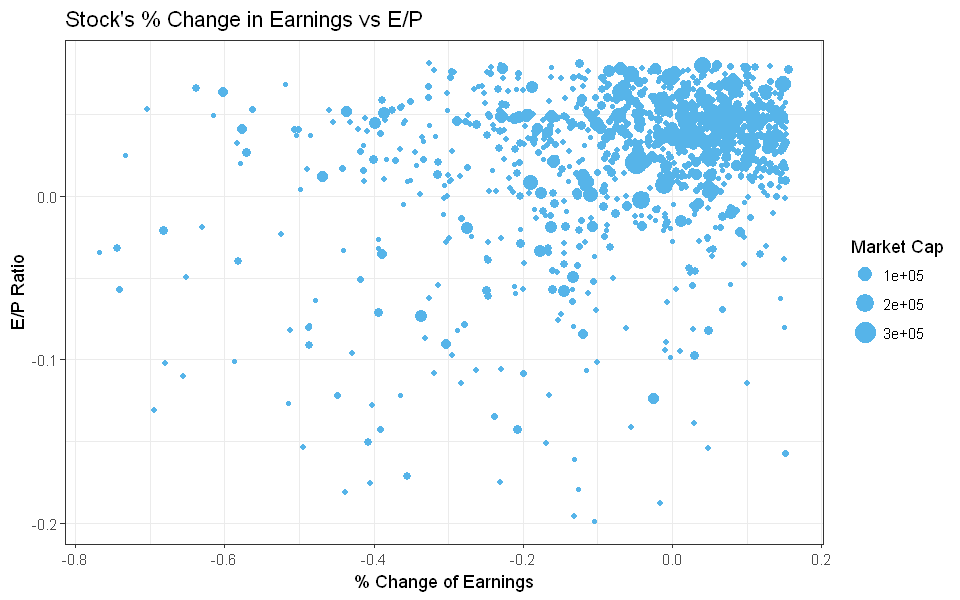

In [253]:
ggplot(data=fundamentals_3yrAvg, aes(x = `% change Earnings`, y = `E/P`, 
                                     size = `Market Cap`, show.legend=F)) +
  theme_bw()+
  geom_point(color="#56B4E9")+
  labs(title = "Stock's % Change in Earnings vs E/P",
  x = "% Change of Earnings", 
  y = "E/P Ratio",
  parse = TRUE)

The stocks with higher market cap tends to have a higher % change in earnings over 3 years and higher P/E ratio. Most of the chosen companies (whose market cap larger than 1000) are profitable and recording positive growth. It is not a fair comparison for these companies though, since each industry tend to have a different market cap